In [48]:
import nn_all
import nn_arch
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from PIL import Image
from skimage import measure
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage import zoom
%matplotlib inline

In [5]:
directory = "mr_fivelayer_3x24_50fc"
combined_pred_stks = pickle.load(open(directory+"/pickles/combined_pred_stks.pickle", 'rb'))
thresholded_pred_stks = pickle.load(open(directory+"/pickles/thresholded_pred_stks.pickle", 'rb'))
pred_stk_roi_labels = pickle.load(open(directory+"/pickles/pred_stk_roi_labels.pickle", 'rb'))
rois = pickle.load(open(directory+"/pickles/final_rois.pickle", 'rb'))
try:
    best_params = pickle.load(open(directory+"/pickles/best_postprocessing_params.pickle", 'rb'))
    print best_params
except:
    pass

((1, 0), 0.77368421052631575, 12.5)


In [52]:
def p(d, cmap="gray"):
    plt.figure(figsize=(5,5))
    plt.imshow(d, cmap=cmap)

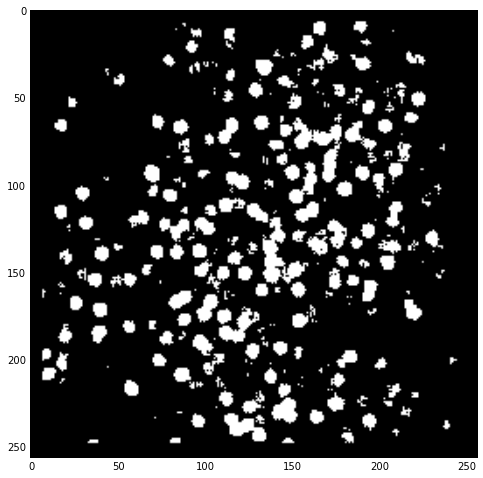

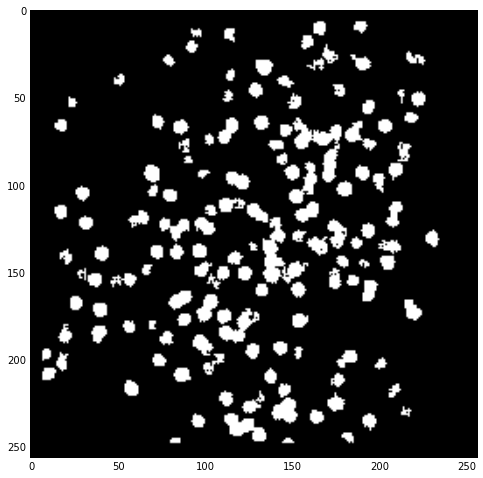

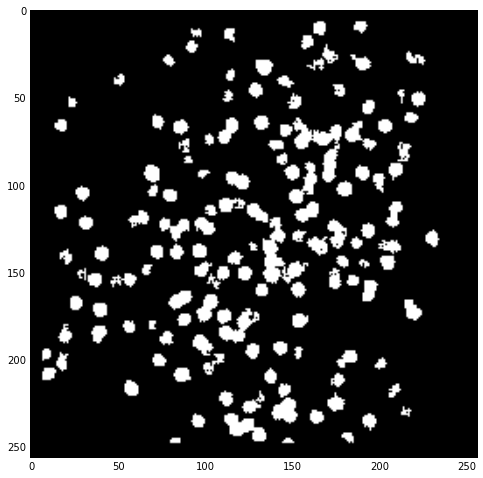

In [7]:
t_im = (combined_pred_stks[0] > 0.5)
p(t_im)
t_im = remove_small_objects(t_im, min_size=15)
#timh = remove_small_holes(t_im, min_size=5)
timh = t_im
p(t_im)
p(timh)

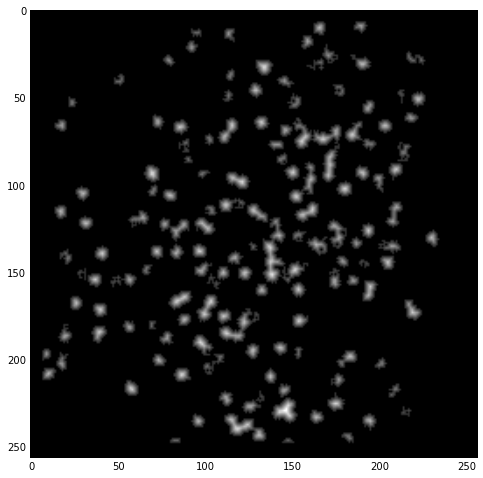

In [8]:
distance = ndi.distance_transform_edt(timh)
p(distance)

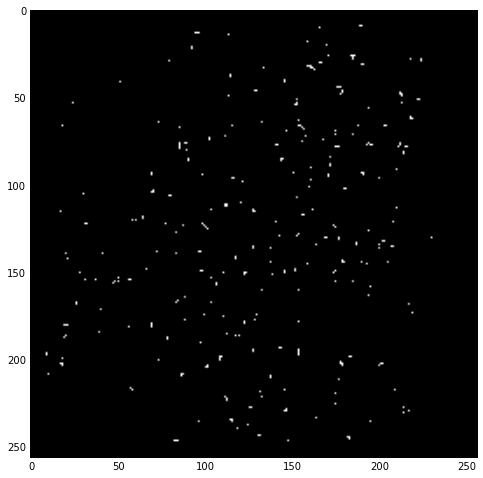

In [9]:
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((6, 6)), labels=timh)
p(local_maxi)

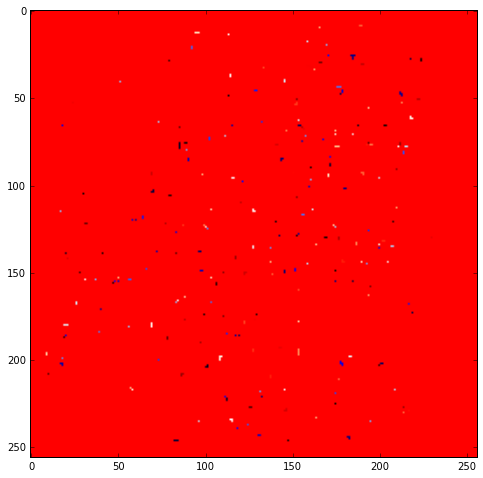

In [10]:
markers = ndi.label(local_maxi)[0]
p(markers, "flag")

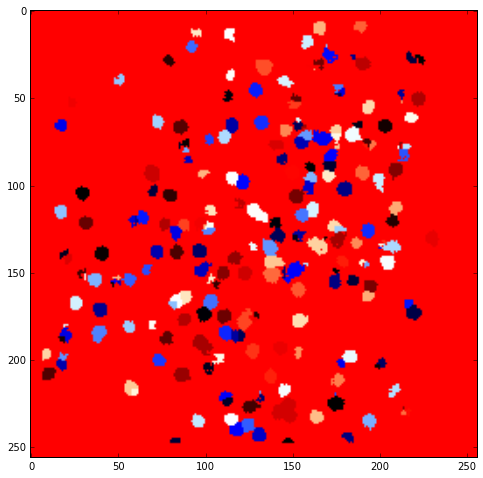

In [11]:
labels = watershed(-distance, markers, mask=timh)
p(labels, "flag")

0.999998629093
5.0


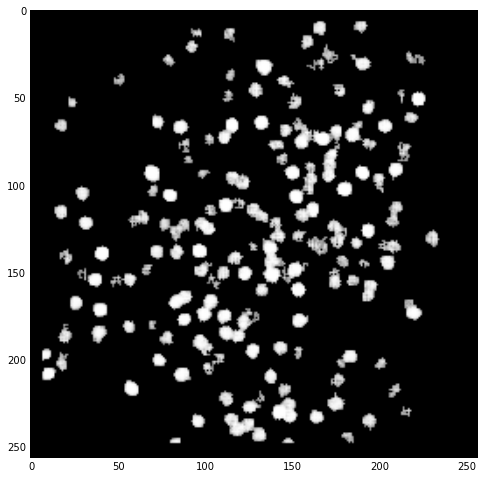

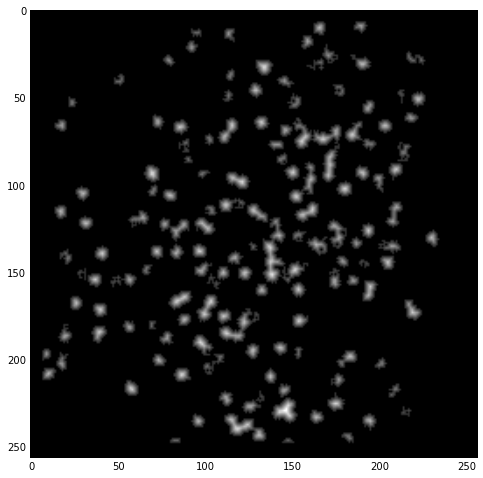

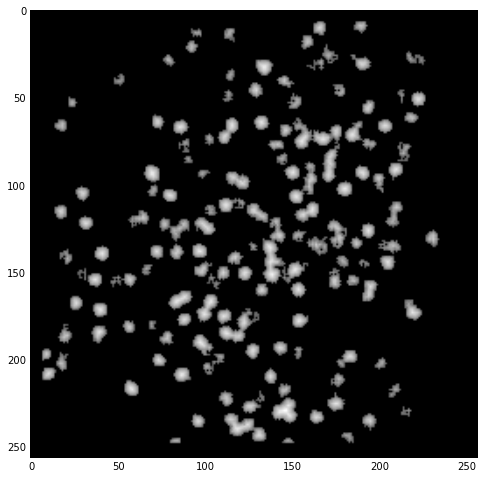

In [12]:
c = combined_pred_stks[0]
c[np.logical_not(timh)] = 0
p(c)
p(distance)
print np.max(c)
print np.max(distance)
c = c + distance/distance.max()
p(c)

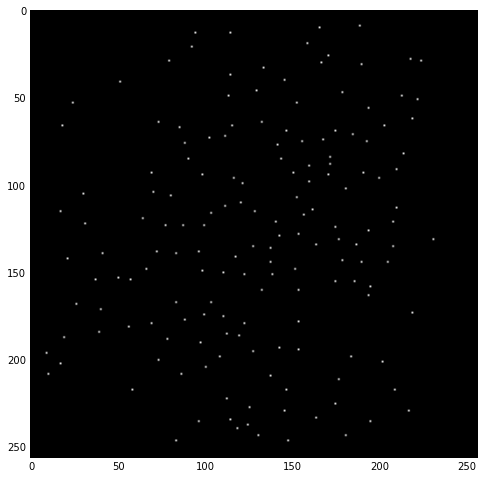

In [13]:
local_maxi = peak_local_max(c, indices=False, footprint=np.ones((8, 8)), labels=timh)
p(local_maxi)

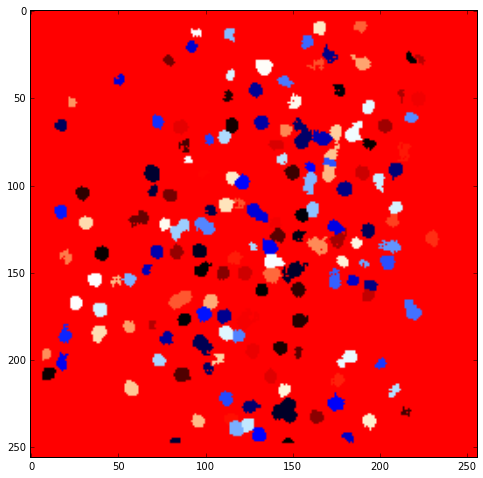

In [33]:
markers = ndi.label(local_maxi)[0]
labels = watershed(-c, markers, mask=timh)
p(labels, "flag")

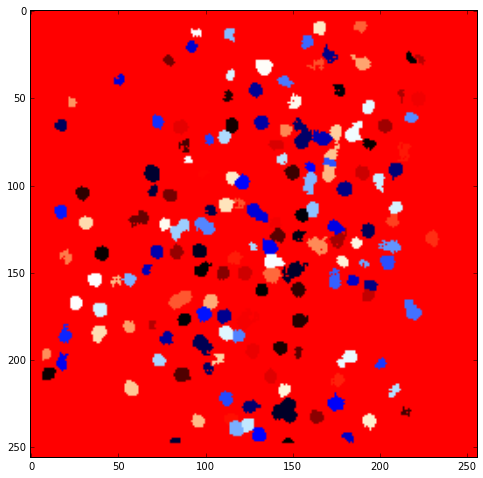

In [43]:
#loop over all watershedded labels, if size is too small, remove label from peak local max markers and re watershed
new_markers = markers.copy()
for i in set(labels.flatten()):
    if i == 0: continue
    if np.sum(labels==i) < 10:
        new_markers[markers==i] = 0
labels = watershed(-c, new_markers, mask=timh)
p(labels, "flag")

In [20]:
print set(markers.flatten())

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163])


In [49]:
labels_set = set(labels.flatten())
rois = []
for label in labels_set:
    if label == 0: continue
    if np.sum((labels==label).astype(int)) < 10: continue
    nroi = np.zeros((256,256))
    cx,cy = np.where(labels==label)
    cx,cy = int(cx.mean()), int(cy.mean())
    x,y = np.ogrid[0:nroi.shape[0], 0:nroi.shape[1]]
    r = 4
    mask =  (cx-x)**2 + (cy-y)**2 <= r*r
    nroi[mask] = 1
    #nroi[labels==label] = 1                                                                                                                                                                          
    rois.append(zoom(nroi, 2, order=0))
rois = np.array(rois)


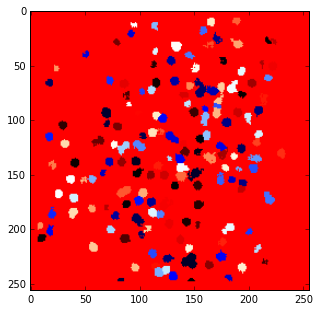

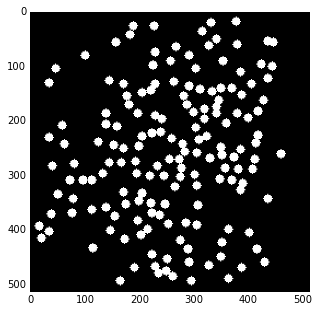

In [53]:
p(labels, "flag")
p(rois.max(axis=0))